<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importation-des-données-en-lien-avec-la-consommation-d'énergie" data-toc-modified-id="Importation-des-données-en-lien-avec-la-consommation-d'énergie-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importation des données en lien avec la consommation d'énergie</a></span></li><li><span><a href="#Représentation-graphique-de-la-série-temporelle-de-la-consommation-d'énergie" data-toc-modified-id="Représentation-graphique-de-la-série-temporelle-de-la-consommation-d'énergie-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Représentation graphique de la série temporelle de la consommation d'énergie</a></span></li><li><span><a href="#Importation-des-données-des-DJU" data-toc-modified-id="Importation-des-données-des-DJU-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Importation des données des DJU</a></span></li></ul></div>

In [1]:
# Importation des librairies nécessaires au projet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
import warnings

# Description de la consommation en énergie

In [2]:
# Chargement du dataset sur la consommation énergétique 
df = pd.read_csv('conso_energie.csv', encoding='latin-1')
df.head()

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
1,2012-02,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2,2012-03,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
3,2012-04,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,...,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
4,2012-05,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,...,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0


On dispose de plusieurs informations sur la consommation en énergie du territoire français. On a des informations concernant la production totale ainsi que le découpage de ces productions (nucléaire, charbon, fioul, gaz, hydraulique, bioénergies), la consommation totale, le solde exportateur ainsi que les échanges avec des pays voisins avec le Royaume-Uni, l'Espagne, l'Italie, la Suisse, l'Allemagne et la Belgique.

## Représentation et statistiques descriptives de la consommation électrique

Pour la suite de cette analyse, on va s'intéresse à la consommation électrique totale du territoire national uniquement. On va créer une variable contenant le logarithme de la consommation électrique pour pouvoir compléter notre analyse de la série temporelle de la consommation.

In [3]:
warnings.filterwarnings('ignore')

df_france = df.loc[(df['Territoire'] == 'France')]
df_france['log_consommation'] = df_france['Consommation totale'].apply(lambda x : np.log(x))

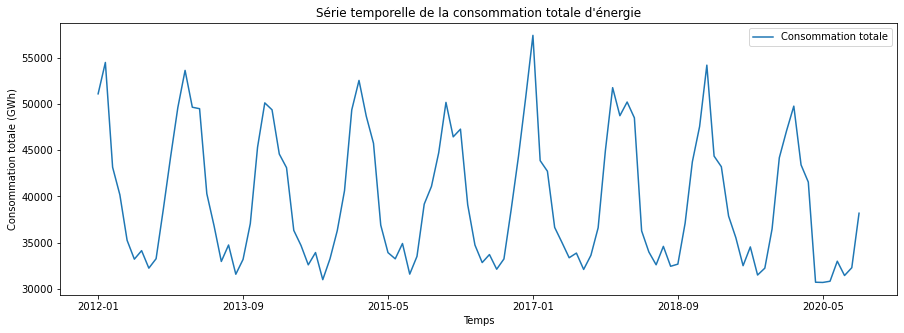

In [4]:
df_france.plot(x='Mois', y='Consommation totale', figsize=(15,5))
plt.xlabel('Temps')
plt.ylabel('Consommation totale (GWh)')
plt.title('Série temporelle de la consommation totale d\'énergie')
plt.show()

Une fois la série temporelle de la consommation totale d'énergie représentée graphiquement, on peut calculer différents indices pour décrire notre série. 

In [5]:
print('Moyenne de la série : ', round(df_france['Consommation totale'].mean(), 2))
print('Médiane de la série : ', round(df_france['Consommation totale'].median(), 2))

Moyenne de la série :  39668.58
Médiane de la série :  36980.5


In [6]:
print('Variance de la série : ', round(df_france['Consommation totale'].var(), 2))
print('Ecart-type de la série : ', round(df_france['Consommation totale'].std(), 2))
print('Etendue de la série : ', round(df_france['Consommation totale'].max() - df_france['Consommation totale'].min(), 2))

Variance de la série :  50656863.25
Ecart-type de la série :  7117.36
Etendue de la série :  26702


On représente ensuite la série temporelle à l'aide de la variable log_consommation. 

[]

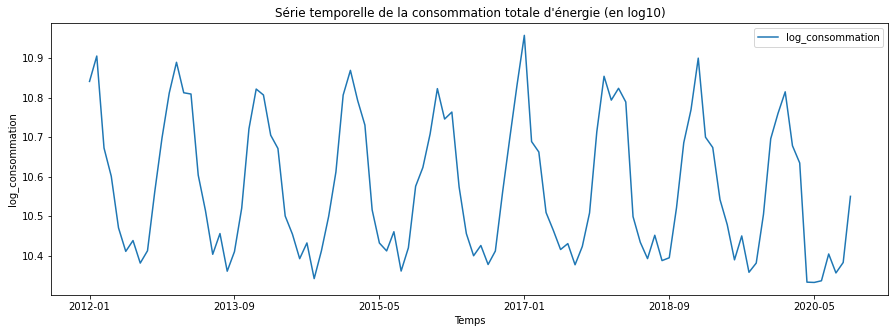

In [7]:
df_france.plot(x='Mois', y='log_consommation',figsize=(15,5))
plt.xlabel('Temps')
plt.ylabel('log_consommation')
plt.title('Série temporelle de la consommation totale d\'énergie (en log10)')
plt.plot()

On remarque que la consommation brute ou transformée par une fonction logarithme ont la même forme. 

# Importation des données des DJU

On s'intéresse ensuuite aux données concernant les variations de température que l'on nomme DJU. Les données téléchargées contiennent les informations de plusieurs villes, on calcule donc la moyenne nationale qui sera utilisée par la suite.

In [8]:
df_dju = pd.read_csv('DJU.csv',  sep=',', encoding='latin-1')
df_dju['DJU_mean'] = (df_dju['DJU_H1a']+df_dju['DJU_H1b']+df_dju['DJU_H1c']+df_dju['DJU_H2a']+df_dju['DJU_H2b']+df_dju['DJU_H2c']+df_dju['DJU_H2d']+df_dju['DJU_H3'])/8
df_dju.head()

,Mois,Territoire_H1a,DJU_H1a,Territoire_H1b,DJU_H1b,Territoire_H1c,DJU_H1c,Territoire_H2d,DJU_H2d,Territoire_H3,DJU_H3,Territoire_H2c,DJU_H2c,Territoire_H2b,DJU_H2b,Territoire_H2a,DJU_H2a,DJU_mean
0,2012-01,St-Quentin,398.1,Charleville-Mézières,430.9,Ambérieu,444.6,St Aubin,366.3,Nice,248.3,Bordeaux,333.6,Cognac,343.8,Brest,303.5,358.6375
1,2012-02,St-Quentin,497.8,Charleville-Mézières,531.8,Ambérieu,574.1,St Aubin,436.4,Nice,304.4,Bordeaux,439.2,Cognac,468.9,Brest,350.5,450.3875
2,2012-03,St-Quentin,276.8,Charleville-Mézières,313.3,Ambérieu,253.4,St Aubin,209.7,Nice,152.8,Bordeaux,201.0,Cognac,206.4,Brest,241.0,231.8000
3,2012-04,St-Quentin,291.4,Charleville-Mézières,294.1,Ambérieu,211.2,St Aubin,204.2,Nice,107.8,Bordeaux,210.4,Cognac,217.9,Brest,276.1,226.6375
4,2012-05,St-Quentin,152.9,Charleville-Mézières,128.4,Ambérieu,90.3,St Aubin,77.3,Nice,48.3,Bordeaux,58.4,Cognac,71.5,Brest,151.8,97.3625


## Représentation graphique des DJU

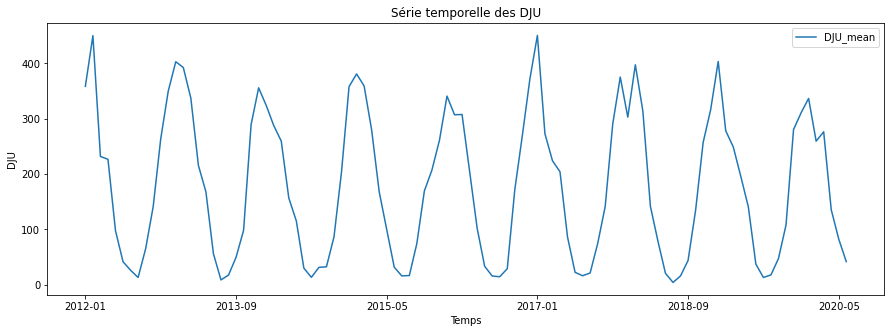

In [9]:
df_dju.plot(x='Mois',y='DJU_mean', figsize=(15,5))
plt.xlabel('Temps')
plt.ylabel('DJU')
plt.title('Série temporelle des DJU')
plt.show()

La silhouette de la série temporelle des DJU suit celle de la consommation d'énergie électrique.

### Corrélation entre Consommation totale et DJU

Avant de corriger la consommation d'énergie à l'aide de la température en degré jour. On crée un dataframe contenant uniquement les informations que l'on va utiliser pour la suite de notre étude. 

In [10]:
df = pd.merge(df_france, df_dju, on ='Mois')
df = df[['Mois', 'Consommation totale', 'DJU_mean']].set_index('Mois')
df.index = pd.to_datetime(df.index)
df.head()

,Consommation totale,DJU_mean
Mois,,
2012-01-01,51086,358.6375
2012-02-01,54476,450.3875
2012-03-01,43156,231.8000
2012-04-01,40176,226.6375
2012-05-01,35257,97.3625


In [11]:
del df_dju
del df_france

On regarde la distribution de nos deux variables.

#### Distribution de la consommation totale d'électricité

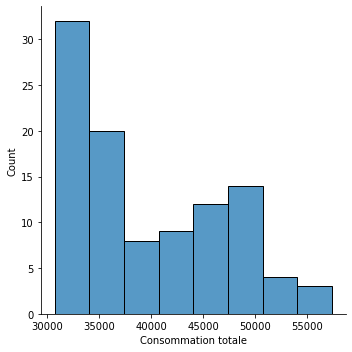

ShapiroResult(statistic=0.908640444278717, pvalue=3.0329144919960527e-06)

In [12]:
sns.displot(df['Consommation totale'])
plt.show()
st.shapiro(df['Consommation totale'])

#### Distribution des températures en DJU

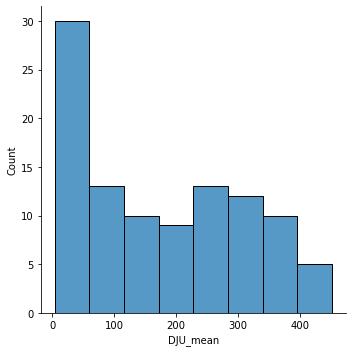

ShapiroResult(statistic=0.917353093624115, pvalue=8.482184966851491e-06)

In [13]:
sns.displot(df['DJU_mean'])
plt.show()
st.shapiro(df['DJU_mean'])

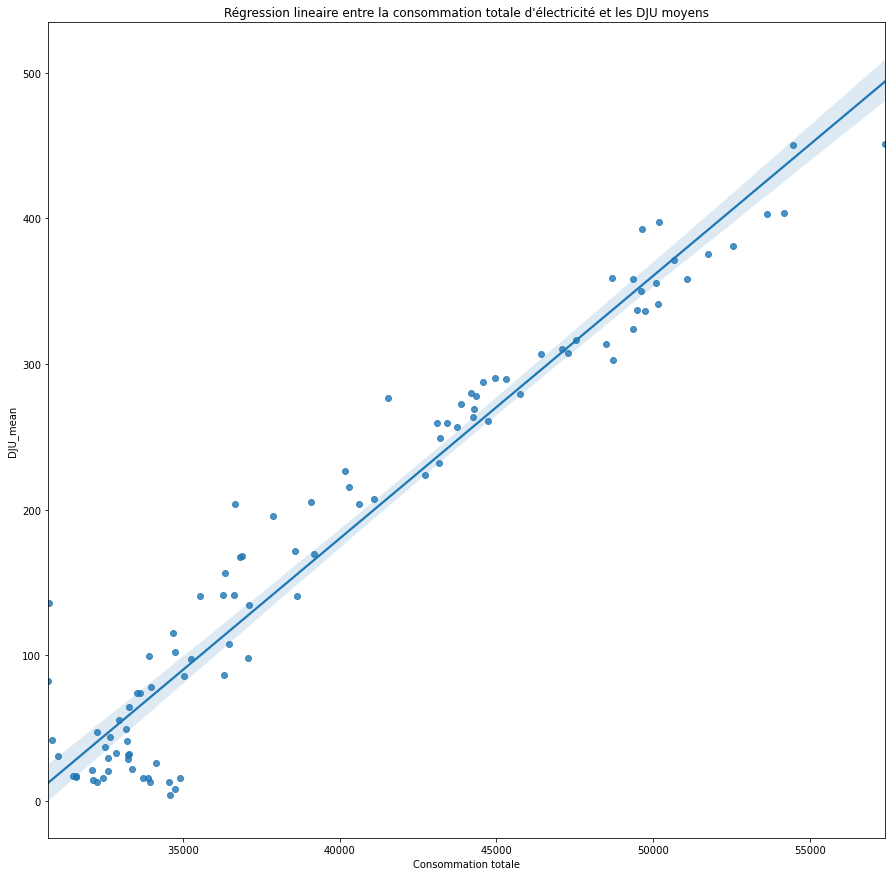

In [14]:
plt.figure(figsize=(15,15))
sns.regplot('Consommation totale', 'DJU_mean', data=df)
plt.title('Régression lineaire entre la consommation totale d\'électricité et les DJU moyens')
plt.show()

In [15]:
X = np.array(df['Consommation totale'])
y = np.array(df['DJU_mean'])

slope, intercept, r_value, p_value, std_err = st.linregress(X,y)
print('r-squared : ', r_value**2)
print('slope :' , slope)

r-squared :  0.9378066929077119
slope : 0.018034418615795977


# Correction et désaisonnalisation des données de consommation

## Désaisonnalisation grâce à une régression linéaire

In [16]:
df['Consommation totale corrigée'] = (df['Consommation totale'] - df['DJU_mean']) * slope
df.head()

,Consommation totale,DJU_mean,Consommation totale corrigée
Mois,,,
2012-01-01,51086,358.6375,914.838491
2012-02-01,54476,450.3875,974.320512
2012-03-01,43156,231.8000,774.112992
2012-04-01,40176,226.6375,720.463527
2012-05-01,35257,97.3625,634.083621


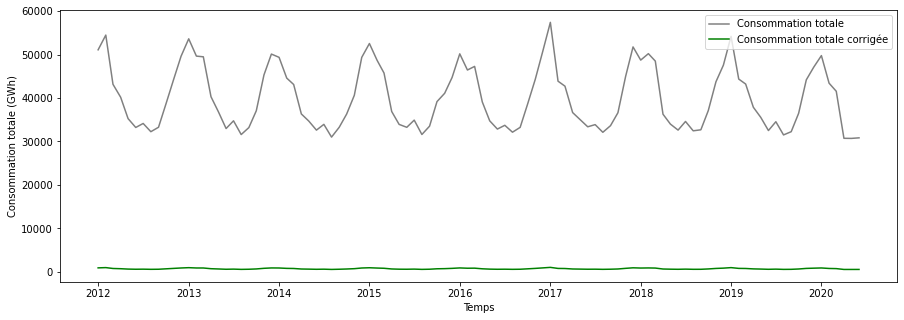

In [17]:
plt.figure(figsize=(15,5))
plt.plot(df['Consommation totale'], label='Consommation totale', color='grey')
plt.plot(df['Consommation totale corrigée'], label='Consommation totale corrigée', color='green')
plt.xlabel('Temps')
plt.ylabel('Consommation totale (GWh)')
plt.legend()
plt.show()

## Désaisonnalisation à l'aide de moyenne mobile

In [18]:
df_decomp = df[['Consommation totale corrigée']]
df_decomp.head()

,Consommation totale corrigée
Mois,
2012-01-01,914.838491
2012-02-01,974.320512
2012-03-01,774.112992
2012-04-01,720.463527
2012-05-01,634.083621


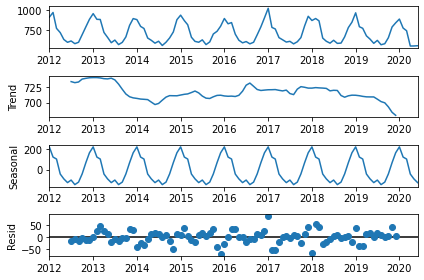

In [19]:
decomp_x = seasonal_decompose(df_decomp,  model='add')
decomp_x.plot()
plt.show()

In [20]:
df['Saisonnalité'] = decomp_x.seasonal

In [21]:
df['Consommation désaisonnalisée'] = df['Consommation totale corrigée'] - df['Saisonnalité']
df.head()

,Consommation totale,DJU_mean,Consommation totale corrigée,Saisonnalité,Consommation désaisonnalisée
Mois,,,,,
2012-01-01,51086,358.6375,914.838491,217.401146,697.437344
2012-02-01,54476,450.3875,974.320512,119.749895,854.570616
2012-03-01,43156,231.8000,774.112992,100.827325,673.285667
2012-04-01,40176,226.6375,720.463527,-42.887403,763.350930
2012-05-01,35257,97.3625,634.083621,-89.446509,723.530130


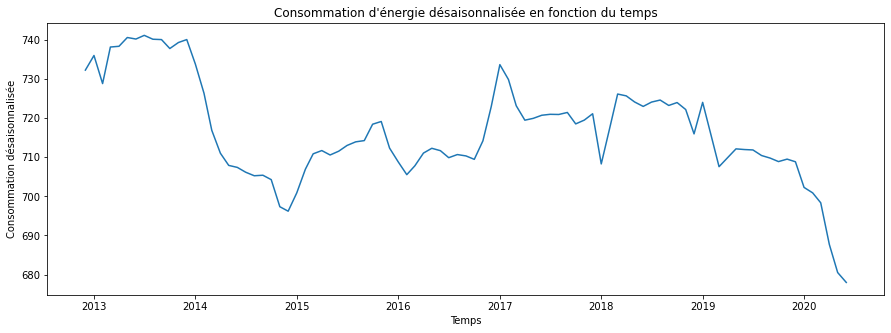

In [22]:
window_size = 12

windows = df['Consommation désaisonnalisée'].rolling(window_size)
moving_averages = windows.mean()

moving_averages_list = moving_averages.tolist()
without_nans = moving_averages_list[window_size - 1:]

plt.figure(figsize=(15,5))
plt.plot(moving_averages)
plt.xlabel('Temps')
plt.ylabel('Consommation désaisonnalisée')
plt.title('Consommation d\'énergie désaisonnalisée en fonction du temps')
plt.show()

## Prédiction à l'aide d'une méthode exponentielle double

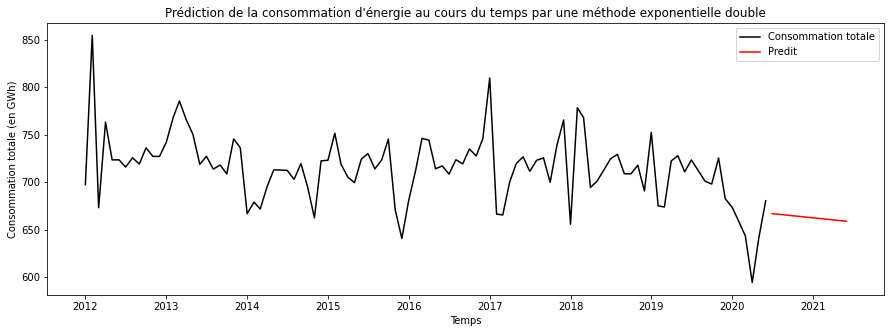

In [23]:
warnings.filterwarnings('ignore')

led = ExponentialSmoothing(np.asarray(df['Consommation désaisonnalisée']), trend='add').fit()
led_pred = led.forecast(12)

plt.figure(figsize=(15,5))
plt.plot(df['Consommation désaisonnalisée'], label='Consommation totale', color='black')
plt.plot(pd.date_range(df['Consommation désaisonnalisée'].index[len(y)-1], periods=12, freq='M'), led_pred, label='Predit', color='red')
plt.legend()
plt.ylabel('Consommation totale (en GWh)')
plt.xlabel('Temps')
plt.title('Prédiction de la consommation d\'énergie au cours du temps par une méthode exponentielle double')
plt.show()

## Modélisation à l'aide de la méthode de Holt-Winters

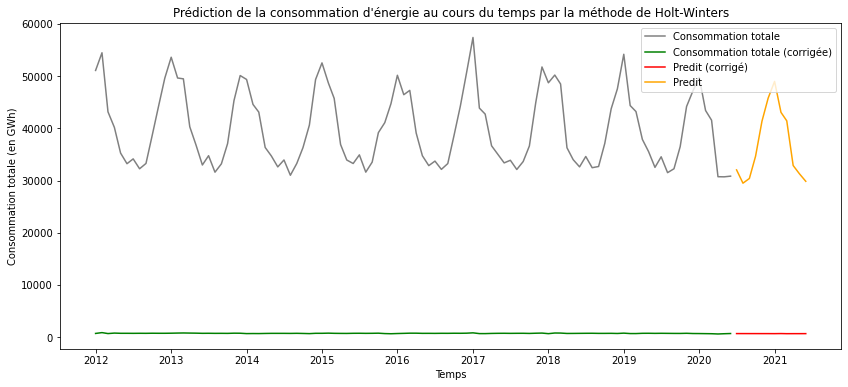

In [24]:
warnings.filterwarnings('ignore')
hw = ExponentialSmoothing(np.asarray(df['Consommation désaisonnalisée']), seasonal_periods=12, trend='add', seasonal='add').fit()
hw2 = ExponentialSmoothing(np.asarray(df['Consommation totale']), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)
hw_pred2 = hw2.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(df['Consommation totale'], label='Consommation totale', color='grey')
plt.plot(df['Consommation désaisonnalisée'], label='Consommation totale (corrigée)', color='green')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'),hw_pred, label='Predit (corrigé)', color='red')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'),hw_pred2, label='Predit', color='orange')
plt.ylabel('Consommation totale (en GWh)')
plt.xlabel('Temps')
plt.title('Prédiction de la consommation d\'énergie au cours du temps par la méthode de Holt-Winters')
plt.legend(loc='best')
plt.show()

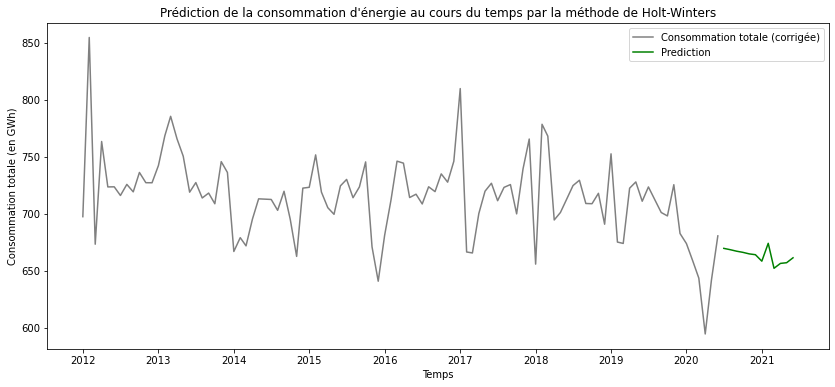

In [25]:
plt.figure(figsize=(14,6))
plt.plot(df['Consommation désaisonnalisée'], label='Consommation totale (corrigée)', color='gray')
plt.plot(pd.date_range(df_decomp.index[len(df)-1], periods=12, freq='M'),hw_pred, label='Prediction', color='green')
plt.ylabel('Consommation totale (en GWh)')
plt.xlabel('Temps')
plt.title('Prédiction de la consommation d\'énergie au cours du temps par la méthode de Holt-Winters')
plt.legend(loc='best')
plt.show()

In [26]:
df_2 = df.drop(df.index[-12:])

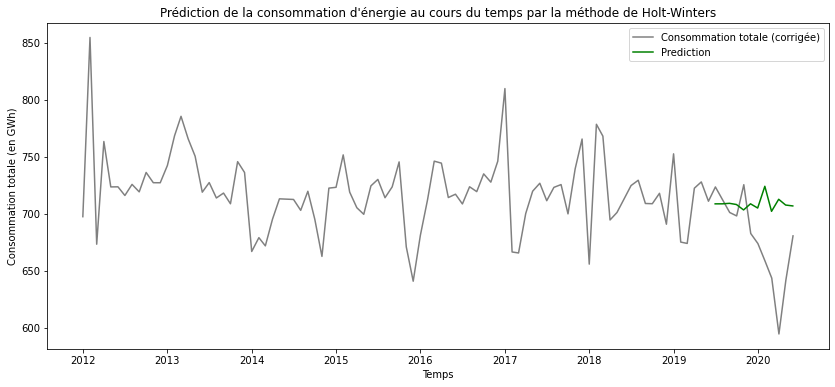

In [27]:
warnings.filterwarnings('ignore')

hw = ExponentialSmoothing(np.asarray(df_2['Consommation désaisonnalisée']), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(df['Consommation désaisonnalisée'], label='Consommation totale (corrigée)', color='gray')
plt.plot(pd.date_range(df_2.index[len(df_2)-1], periods=12, freq='M'), hw_pred, label='Prediction', color='green')
plt.ylabel('Consommation totale (en GWh)')
plt.xlabel('Temps')
plt.title('Prédiction de la consommation d\'énergie au cours du temps par la méthode de Holt-Winters')
plt.legend(loc='best')
plt.show()

In [28]:
y_pred = hw_pred
y_true = np.asarray(df['Consommation désaisonnalisée'].iloc[-12:])

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
print('MAE = ', mae)
print('MSE = ', mse)
print('MAPE = ', mape)

MAE =  37.52499747173735
MSE =  2438.5474088949527
MAPE =  5.807462463104535


## Prédiction à l'aide d'un méthode SARIMA